1. Загрузка библиотек и настройка параметров

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import random
import platform

In [2]:
# Фиксация всех случайных seed для воспроизводимости
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # если используются многопоточные GPU
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(SEED)  # если используется стандартный модуль random


# Для воспроизводимости DataLoader при использовании многопоточности
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

In [3]:
# Определяем параметры в зависимости от ОС
if platform.system() == "Windows":
    num_workers = 0  # На Windows рекомендуется использовать 0, чтобы избежать проблем с производительностью и совместимостью. :contentReference[oaicite:2]{index=2}
    torch.multiprocessing.set_start_method(
        "spawn", force=True
    )  # Windows использует метод 'spawn' для запуска процессов.
else:
    num_workers = (
        os.cpu_count()
    )  # На Linux можно использовать количество ядер процессора для num_workers.
    # Linux по умолчанию использует метод 'fork', который обычно работает быстрее.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

2. Подготовка и предобработка данных

2.1. Датасеты

В статье используются публичные датасеты, содержащие как нормальный сетевой трафик, так и аномальные/злоумышленные потоки. Например, можно попробовать использовать:

- USTC-TFC (University of Science and Technology of China – Traffic Flow Collection)

- Другие датасеты для сетевого обнаружения аномалий

2.2. Предобработка

Согласно статье, на вход модели подаются первые n пакетов каждого сетевого потока, причем:

- Фильтрация: Выбираются пакеты, принадлежащие одному 5-тuple (IP-адреса, порты, протокол).

- Анонимизация: MAC- и IP-адреса маскируются.

- Трансформация: Каждый пакет приводится к фиксированной длине l (если пакет длиннее – усечение, если короче – дополнение нулями).

- Нормализация: Значения байтов нормализуются (например, делением на 255).

- Конкатенация: n пакетов объединяются в единый входной вектор.

Пример кода для обработки может выглядеть следующим образом (упрощённо):

In [5]:
# Класс Dataset для загрузки данных из CSV
class CSVAttackDataset(Dataset):
    def __init__(self, attack_dir, data_type='normal', transform=None):
        """
        attack_dir: путь к папке с CSV-файлами атаки (например, 'sql-inj')
        data_type: 'attack' или 'normal'
        """
        self.file_path = os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_{data_type}.csv")
        self.data = self._load_and_filter_data()
        self.transform = transform

    def _load_and_filter_data(self):
        if not os.path.exists(self.file_path):
            return pd.DataFrame()

        df = pd.read_csv(self.file_path)
        # Фильтрация данных (для обучения используем только нормальный трафик)
        df = df[df['label'] == 0] if 'normal' in self.file_path else df
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        # Извлекаем байты и нормализуем в [0, 1]
        features = sample.filter(like='byte_').values.astype(np.float32) / 255.0
        tensor = torch.tensor(features, dtype=torch.float32)
        # Добавляем размерность канала: [1, input_length]
        return tensor.unsqueeze(0)

In [6]:
# Класс для комбинированного тестового набора
class CombinedTestDataset(Dataset):
    def __init__(self, attack_dir):
        attack_df = pd.read_csv(os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_attack.csv"))
        normal_df = pd.read_csv(os.path.join(attack_dir, f"{os.path.basename(attack_dir)}_normal.csv"))
        self.data = pd.concat([attack_df, normal_df], ignore_index=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = sample.filter(like='byte_').values.astype(np.float32) / 255.0
        label = sample['label']
        return torch.tensor(features).unsqueeze(0), torch.tensor(label, dtype=torch.float32)

3. Модель и архитектура

ARCADE состоит из двух компонентов:

3.1. Автоэнкодер (AE)

Используется компактная свёрточная архитектура (inspired by DCGAN) для кодирования и декодирования входных сетевых потоков.

Основная идея:

- Encoder: Преобразует входной сигнал в компактное латентное представление.

- Decoder: Восстанавливает исходный сигнал из латентного представления.

3.2. Критик (Critic)

Отдельная нейросеть, выполняющая роль дискриминатора (как в WGAN-GP), оценивающая, насколько реконструкция (выход AE) соответствует нормальному распределению трафика. При обучении используется штраф за градиент (gradient penalty) для соблюдения условий липшицевости.

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
                # Вход: (batch, 1, 500)
                nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),  # Выход: (16, 250)
                nn.BatchNorm1d(16),
                nn.LeakyReLU(),

                nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # Выход: (32, 125)
                nn.BatchNorm1d(32),
                nn.LeakyReLU(),

                nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),  # Выход: (64, 62)
                nn.BatchNorm1d(64),
                nn.LeakyReLU(),

                nn.Flatten(),
                nn.Linear(64 * 62, 50, bias=False)  # Было: 64*25, теперь: 64*62 = 3968 входов
                )

    def forward(self, x):
        return self.model(x)

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
                # Вход: (batch, 50)
                nn.Linear(50, 64 * 62, bias=False),  # Теперь 64*62 = 3968 выходов
                nn.Unflatten(1, (64, 62)),  # Восстановление формы (64, 62)

                nn.BatchNorm1d(64),
                nn.ReLU(),

                # Первая транспонированная свёртка:
                # Требуем получить выходную длину 125 из входа длиной 62.
                nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=1),  # Выход: (32, 125)
                nn.BatchNorm1d(32),
                nn.ReLU(),

                # Вторая транспонированная свёртка: 125 → 250
                nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),  # Выход: (16, 250)
                nn.BatchNorm1d(16),
                nn.ReLU(),

                # Третья транспонированная свёртка: 250 → 500
                nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),  # Выход: (1, 500)
                nn.Sigmoid()
                )

    def forward(self, x):
        return self.model(x)

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [10]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
                # Вход: (batch, 1, 500)
                nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1),  # Выход: (16, 250)
                nn.LayerNorm([16, 250]),
                nn.LeakyReLU(),

                nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # Выход: (32, 125)
                nn.LayerNorm([32, 125]),
                nn.LeakyReLU(),

                nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),  # Выход: (64, 62)
                nn.LayerNorm([64, 62]),
                nn.LeakyReLU(),

                nn.Flatten(),
                nn.Linear(64 * 62, 50, bias=False),  # Было: 64*25, теперь: 64*62
                nn.LayerNorm(50),
                nn.LeakyReLU(),

                nn.Linear(50, 1, bias=False)  # Параметры: 50*1 = 50
                )

    def forward(self, x):
        return self.model(x)

4. Функции потерь и штраф за градиент

4.1. Функция реконструкции

Чаще всего используется MSE (Mean Squared Error) или L1 loss:

4.2. Adversarial loss (WGAN-GP)

Критик обучается по следующему принципу:

- Максимизировать оценку для реальных нормальных потоков.

- Минимизировать оценку для реконструкций, полученных автоэнкодером.

При этом применяется штраф за градиент, как описано в статье (см. уравнение (4)).

Пример функции для расчёта gradient penalty:

In [11]:
def compute_gradient_penalty(critic, real_data, fake_data, device, lambda_gp=10):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1, device=device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)
    critic_interpolates = critic(interpolates)
    gradients = grad(
            outputs=critic_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(critic_interpolates, device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
            )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

5. Процедура обучения

5.1. Стратегия обучения

Архитектура обучается по схеме adversarial training:

- Шаг 1. Обучение критика:
    - Используйте реальные нормальные данные и реконструкции автоэнкодера.

    - Обновляйте веса критика, максимизируя разницу между оценками (реальные – реконструированные), добавляя штраф за градиент.

- Шаг 2. Обучение автоэнкодера:

    - Минимизируйте комбинированную функцию потерь, состоящую из ошибки реконструкции и adversarial loss (то есть, ошибка между оценкой критика для реконструкций и целевым значением).

5.2. Пример цикла обучения

Ниже приведён псевдокод, демонстрирующий общий цикл обучения:

In [12]:
def evaluate_validation(autoencoder, val_loader, device, reconstruction_criterion):
    autoencoder.eval()
    val_loss = 0.0
    count = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            reconstruction = autoencoder(data)
            loss = reconstruction_criterion(reconstruction, data)
            val_loss += loss.item() * data.size(0)
            count += data.size(0)
    autoencoder.train()
    return val_loss / count

In [13]:
def train_arcade(
    autoencoder,
    critic,
    train_loader,
    val_loader,
    device,
    searching_epochs=100,
    fine_tuning_epochs=50,
    lr_searching=1e-4,
    lr_finetuning=1e-5,
    lambda_gp=10,
    lambda_adv=0.01,
    critic_iters=5,
    balance_threshold=0.001,
    balance_patience=5,
    early_stopping_patience=10,
):
    total_epochs = searching_epochs + fine_tuning_epochs

    # Инициализация оптимизаторов с β1=0, β2=0.9
    optimizer_AE = optim.Adam(autoencoder.parameters(), lr=lr_searching, betas=(0, 0.9))
    optimizer_Critic = optim.Adam(critic.parameters(), lr=lr_searching, betas=(0, 0.9))

    reconstruction_criterion = nn.MSELoss()

    best_val_loss = float("inf")
    epochs_without_improvement = 0
    balance_counter = (
        0  # Количество последовательных эпох, когда разница лоссов меньше порога
    )

    epoch = 0
    while epoch < total_epochs:
        total_loss_ae = 0.0
        total_loss_critic = 0.0
        num_batches = 0

        # Если перешли в фазу fine-tuning, обновляем lr оптимизаторов
        if epoch == searching_epochs:
            for param_group in optimizer_AE.param_groups:
                param_group["lr"] = lr_finetuning
            for param_group in optimizer_Critic.param_groups:
                param_group["lr"] = lr_finetuning

        batch_pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"Epoch {epoch + 1}/{total_epochs}",
            unit="batch",
            leave=False,
        )

        for _, real_data in batch_pbar:
            real_data = real_data.to(device)

            # Обновление критика (несколько итераций)
            critic_loss_epoch = 0.0
            for _ in range(critic_iters):
                optimizer_Critic.zero_grad()
                reconstruction = autoencoder(real_data)
                critic_real = critic(real_data)
                critic_fake = critic(reconstruction.detach())
                gp = compute_gradient_penalty(
                    critic, real_data, reconstruction.detach(), device, lambda_gp
                )
                loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
                loss_critic.backward()
                optimizer_Critic.step()
                critic_loss_epoch += loss_critic.item()
            avg_critic_loss = critic_loss_epoch / critic_iters

            # Обновление автоэнкодера
            optimizer_AE.zero_grad()
            reconstruction = autoencoder(real_data)
            loss_reconstruction = reconstruction_criterion(reconstruction, real_data)
            loss_adv = -torch.mean(critic(reconstruction))
            loss_AE = loss_reconstruction + lambda_adv * loss_adv
            loss_AE.backward()
            optimizer_AE.step()

            total_loss_ae += loss_AE.item()
            total_loss_critic += avg_critic_loss
            num_batches += 1

            batch_pbar.set_postfix(
                {
                    "MSE Loss": f"{loss_reconstruction:.4f}",
                    "AE Loss": f"{loss_AE.item():.4f}",
                    "Critic Loss": f"{avg_critic_loss:.4f}",
                }
            )
            # tqdm.write(
            #     f"MSE Loss: {loss_reconstruction:.4f}, AE Loss: {loss_AE.item():.4f}, Critic Loss: {avg_critic_loss:.4f}"
            # )

        batch_pbar.close()

        avg_ae_loss = total_loss_ae / num_batches
        avg_critic_loss = total_loss_critic / num_batches

        # Проверка условия балансировки лоссов
        if abs(avg_ae_loss - avg_critic_loss) < balance_threshold:
            balance_counter += 1
        else:
            balance_counter = 0

        # Вычисляем ошибку на валидационном наборе
        val_loss = evaluate_validation(
            autoencoder, val_loader, device, reconstruction_criterion
        )
        # print(
        #     f"- Epoch {epoch + 1}: Avg AE Loss = {avg_ae_loss:.4f}, Avg Critic Loss = {avg_critic_loss:.4f}, Val Loss = {val_loss:.4f}"
        # )

        # Раннее прекращение по валидации
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Если баланс достигнут в течение balance_patience эпох или нет улучшения валидации
        if balance_counter >= balance_patience:
            print("Баланс между лоссами достигнут, остановка обучения.")
            break
        if epochs_without_improvement >= early_stopping_patience:
            print("Нет улучшения на валидации, early stopping.")
            break

        epoch += 1
    print("Обучение завершено.")

In [14]:
def evaluate_metrics(autoencoder, dataloader, device):
    all_scores = []
    all_labels = []
    autoencoder.eval()

    # Сбор ошибок реконструкции и меток для всех примеров
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            reconstruction = autoencoder(data)
            # Вычисление ошибки реконструкции (например, среднеквадратичная ошибка по каждому примеру)
            scores = torch.mean((data - reconstruction) ** 2, dim=[1, 2]).cpu().numpy()
            all_scores.extend(scores)
            all_labels.extend(labels.cpu().numpy())

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # Вычисление AUROC без пороговой бинаризации
    auroc = roc_auc_score(all_labels, all_scores)

    # Подбор порога на основе максимизации F1-метрики
    thresholds = np.linspace(np.min(all_scores), np.max(all_scores), num=100)
    f1_scores = []
    for thr in thresholds:
        preds = (all_scores > thr).astype(int)
        f1 = f1_score(all_labels, preds)
        f1_scores.append(f1)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Применение оптимального порога для вычисления остальных метрик
    predictions = (all_scores > best_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    precision = precision_score(all_labels, predictions)
    recall = recall_score(all_labels, predictions)
    f1 = f1_score(all_labels, predictions)

    # Вычисление матрицы ошибок
    tn, fp, fn, tp = confusion_matrix(all_labels, predictions).ravel()

    print(f"AUROC: {auroc:.4f}")
    print(f"Лучший threshold: {best_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Матрица ошибок:")
    print(f"TN: {tn:.4f}")
    print(f"FP: {fp:.4f}")
    print(f"FN: {fn:.4f}")
    print(f"TP: {tp:.4f}")

    # ------------------ Построение графиков ------------------

    # 1. Гистограмма распределения ошибок реконструкции
    plt.figure(figsize=(12, 5))
    plt.hist(all_scores[all_labels == 0], bins=50, alpha=0.6, label='Нормальные')
    plt.hist(all_scores[all_labels == 1], bins=50, alpha=0.6, label='Аномалии')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Лучший threshold: {best_threshold:.4f}')
    plt.xlabel('Ошибка реконструкции')
    plt.ylabel('Количество примеров')
    plt.title('Распределение ошибок реконструкции')
    plt.legend()
    plt.show()

    # 2. ROC-кривая
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC кривая')
    plt.legend(loc='lower right')
    plt.show()

    # 3. Зависимость F1-score от порога
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.title('Зависимость F1-score от порога')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Лучший threshold: {best_threshold:.4f}')
    plt.legend()
    plt.show()

    return auroc, predictions, accuracy, precision, recall, f1, tn, fp, fn, tp, roc_auc

In [15]:
results = []

In [16]:
def train_attack_category(attack_category, base_dir='n_packets=5_l=100'):
    print(f"\n< ---------- {attack_category} ---------- >")

    # Создаем Dataset только для нормального трафика для обучения
    train_dataset = CSVAttackDataset(
            attack_dir=os.path.join(base_dir, attack_category),
            data_type='normal'
            )

    # Разбиение на train/validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Тестовый набор (attack + normal)
    test_dataset = CombinedTestDataset(os.path.join(base_dir, attack_category))

    # Создаем DataLoader-ы
    batch_size = 32

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,  # <- для воркеров
        generator=g,  # <- для перемешивания
        num_workers=num_workers,
        pin_memory=(
            device.type == "cuda"
        ),  # Рекомендуется при использовании GPU для ускорения передачи данных.
    )

    val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            worker_init_fn=seed_worker,  # важно, если есть аугментации
            generator=g  # не влияет при shuffle=False, но для единообразия
            )

    test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            worker_init_fn=seed_worker,  # если есть преобразования данных
            generator=g  # можно опустить, но лучше оставить
            )

    # Инициализация моделей
    autoencoder = Autoencoder().to(device)
    critic = Critic().to(device)

    # Обучение ARCADE
    searching_epochs = 10  # Фаза "searching"
    fine_tuning_epochs = 5  # Фаза "fine-tuning"
    train_arcade(autoencoder, critic, train_dataloader, val_dataloader, device)

    # Оценка и сохранение метрик
    auroc, predictions, accuracy, precision, recall, f1, tn, fp, fn, tp, roc_auc = evaluate_metrics(
            autoencoder,
            test_dataloader,
            device
            )

    # Добавляем результат в список
    results.append({
            'Attack Category': attack_category,
            'AUROC'          : auroc,
            'Accuracy'       : accuracy,
            'Precision'      : precision,
            'Recall'         : recall,
            'F1 Score'       : f1,
            'True Negative'  : tn,
            'False Positive' : fp,
            'False Negative' : fn,
            'True Positive'  : tp,
            'ROC AUC'        : roc_auc
            }
            )
    print()


< ---------- botnet-ares ---------- >


Epoch 1/150:   0%|          | 0/194 [00:00<?, ?batch/s]c:\Users\nemo\anaconda3\envs\cuda\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.4548
Лучший threshold: 0.0000
Accuracy: 0.4772
Precision: 0.4772
Recall: 1.0000
F1: 0.6461
Матрица ошибок:
TN: 1.0000
FP: 6882.0000
FN: 0.0000
TP: 6281.0000


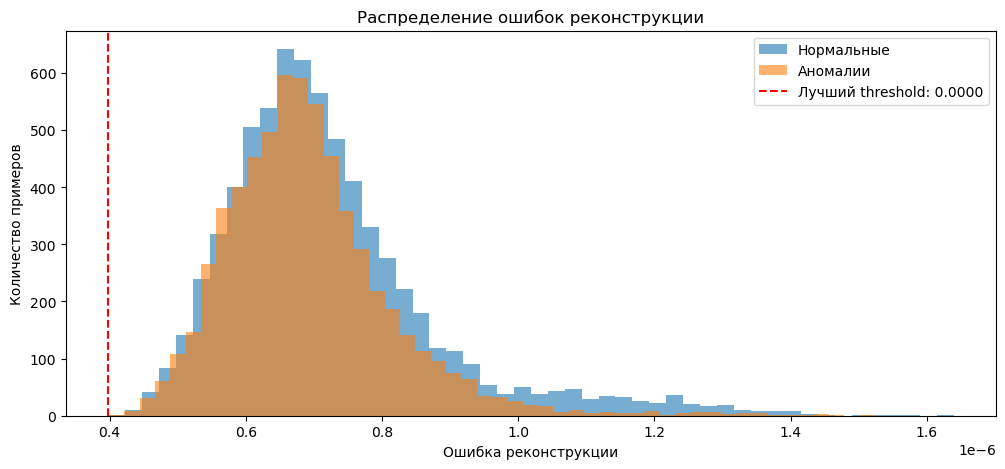

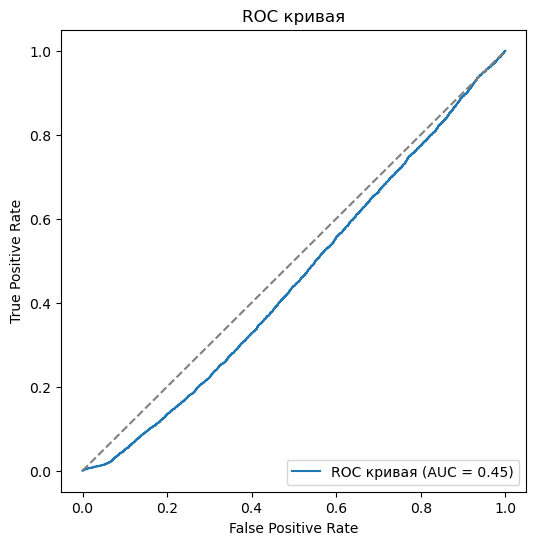

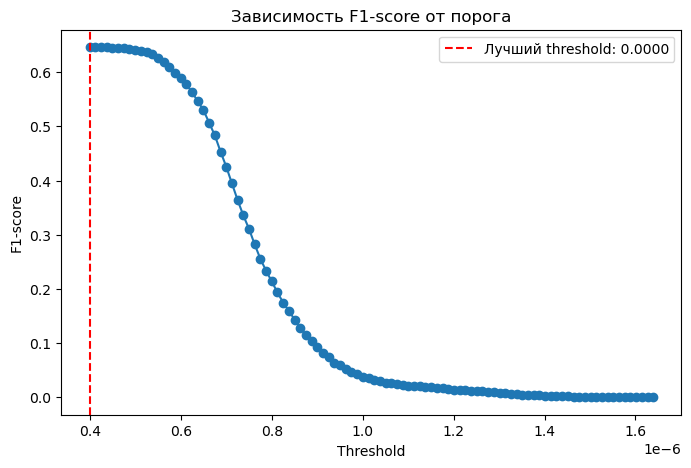

In [17]:
train_attack_category('botnet-ares')


< ---------- brute-ftp ---------- >


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.6020
Лучший threshold: 0.0027
Accuracy: 0.9396
Precision: 0.9396
Recall: 1.0000
F1: 0.9689
Матрица ошибок:
TN: 1.0000
FP: 553.0000
FN: 0.0000
TP: 8604.0000


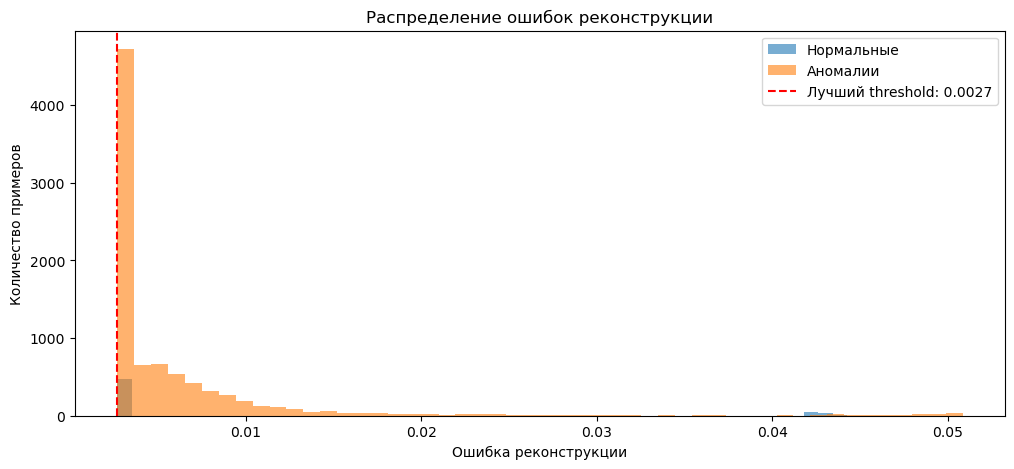

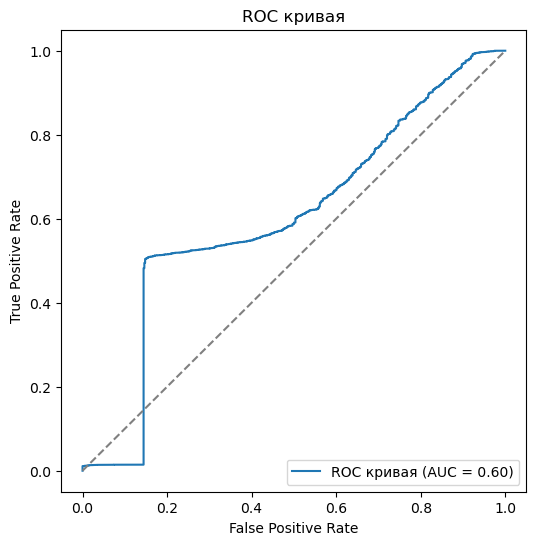

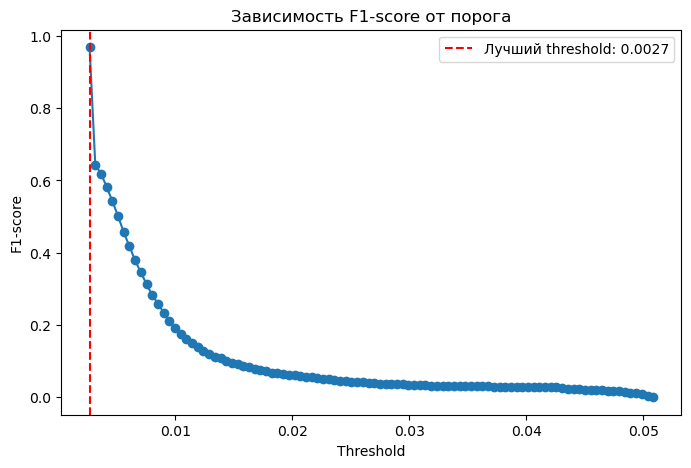

In [18]:
train_attack_category('brute-ftp')


< ---------- brute-http ---------- >


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.6607
Лучший threshold: 0.0666
Accuracy: 0.5459
Precision: 0.5453
Recall: 1.0000
F1: 0.7058
Матрица ошибок:
TN: 1.0000
FP: 391.0000
FN: 0.0000
TP: 469.0000


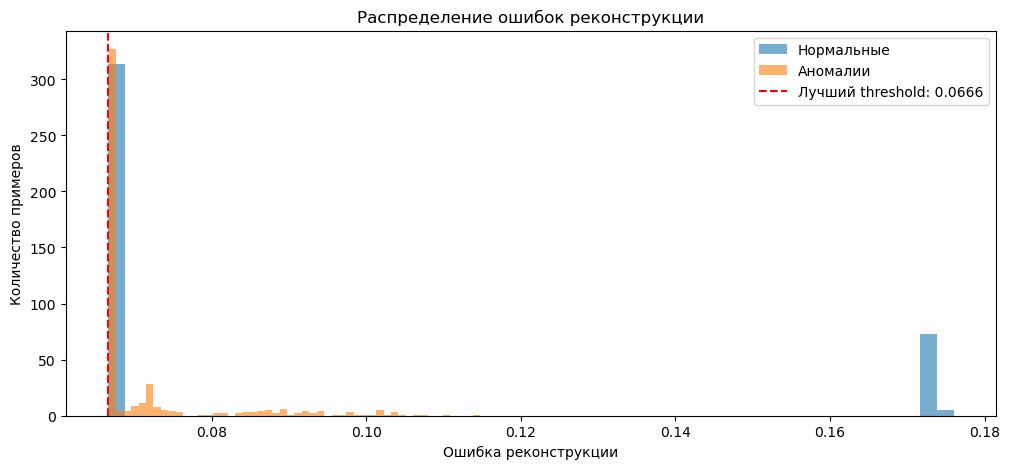

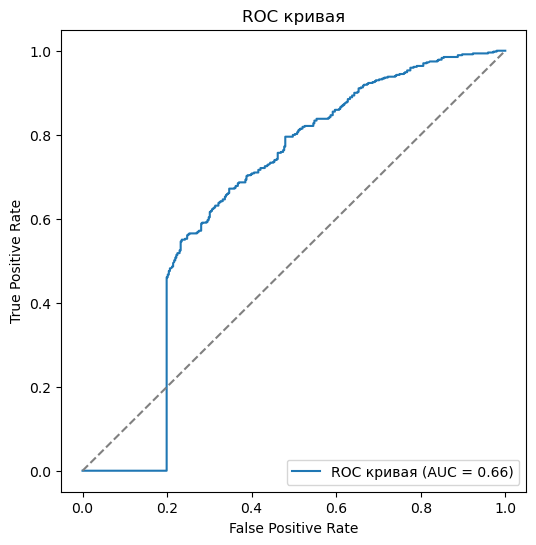

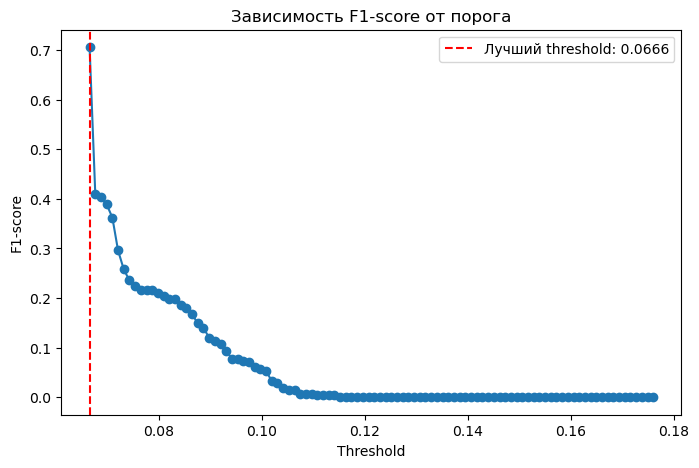

In [19]:
train_attack_category('brute-http')


< ---------- brute-ssh ---------- >


Обучение завершено.
AUROC: 0.5724
Лучший threshold: 0.0007
Accuracy: 0.8899
Precision: 0.8901
Recall: 0.9998
F1: 0.9418
Матрица ошибок:
TN: 0.0000
FP: 702.0000
FN: 1.0000
TP: 5685.0000


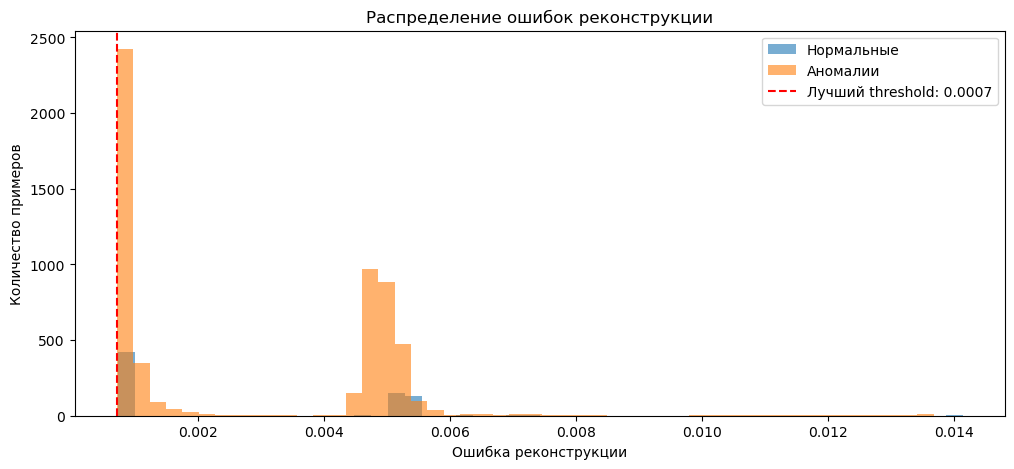

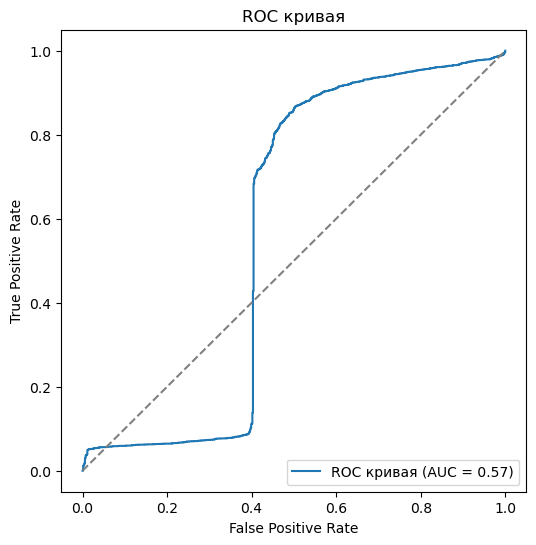

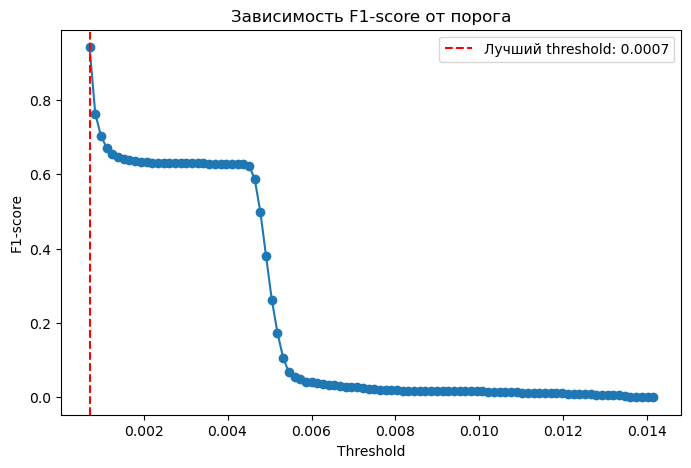

In [20]:
train_attack_category('brute-ssh')


< ---------- inf-dropbox ---------- >


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.5780
Лучший threshold: 0.0000
Accuracy: 0.6648
Precision: 0.6649
Recall: 0.9995
F1: 0.7985
Матрица ошибок:
TN: 2.0000
FP: 1990.0000
FN: 2.0000
TP: 3948.0000


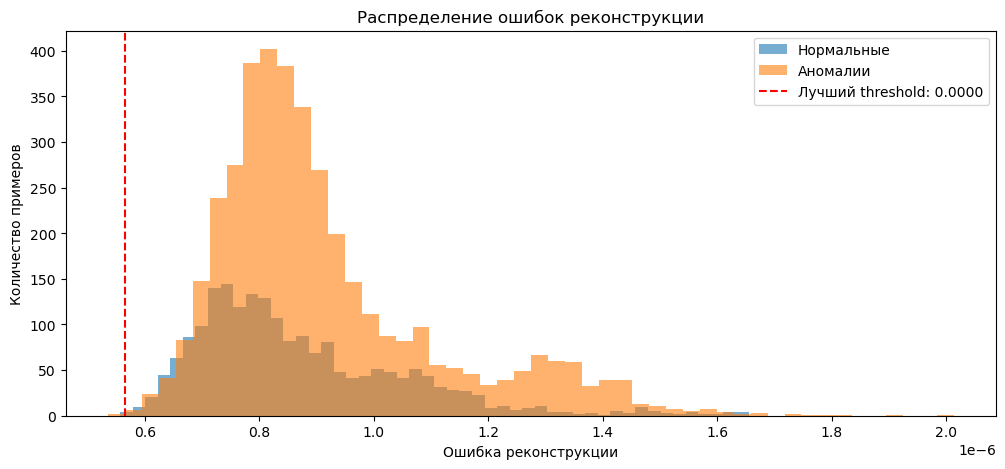

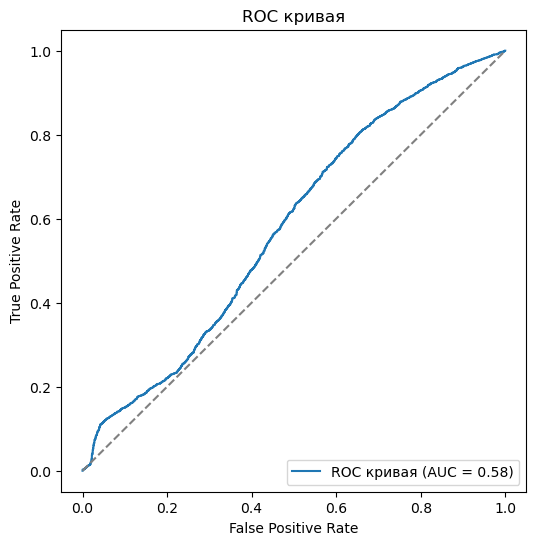

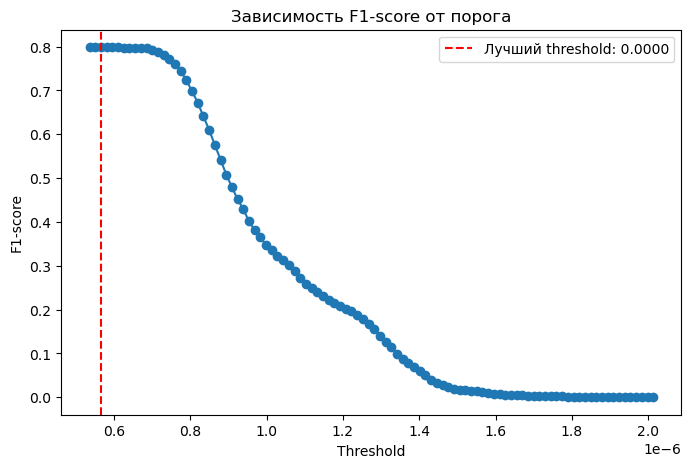

In [21]:
train_attack_category('inf-dropbox')


< ---------- inf-usb ---------- >


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.7995
Лучший threshold: 0.0142
Accuracy: 0.9437
Precision: 0.9443
Recall: 0.9993
F1: 0.9710
Матрица ошибок:
TN: 0.0000
FP: 86.0000
FN: 1.0000
TP: 1458.0000


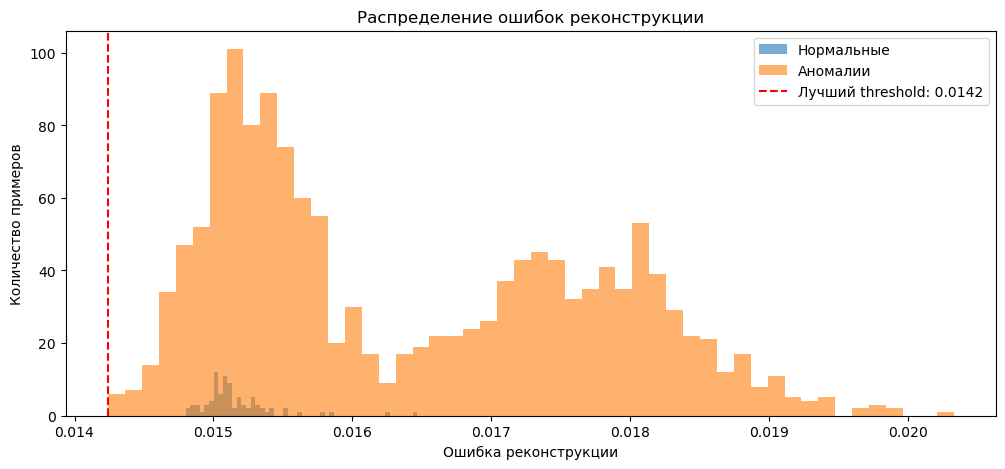

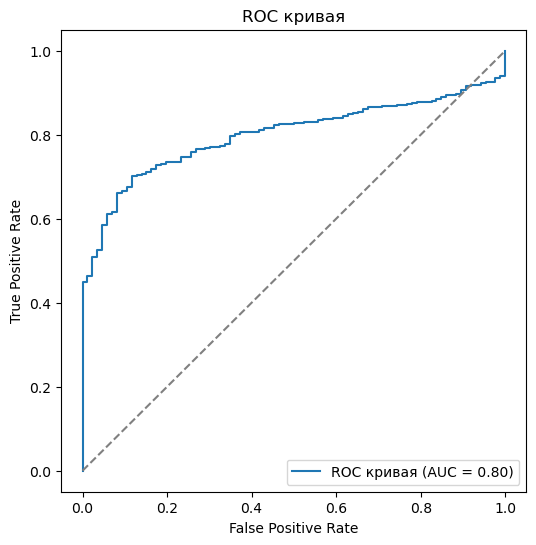

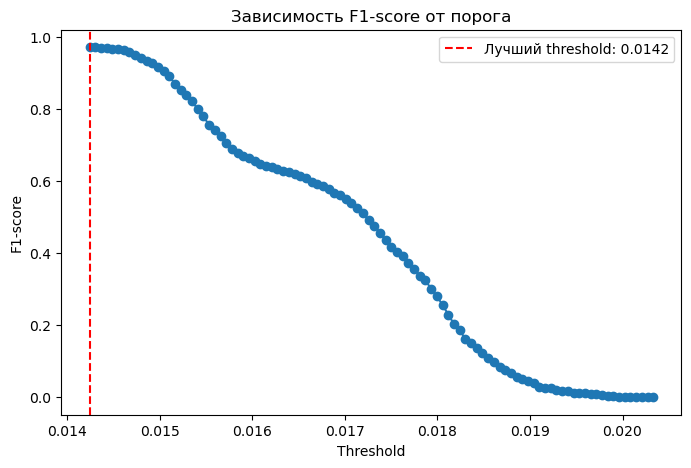

In [22]:
train_attack_category('inf-usb')


< ---------- sql-inj ---------- >


Нет улучшения на валидации, early stopping.
Обучение завершено.
AUROC: 0.8542
Лучший threshold: 0.1351
Accuracy: 0.8571
Precision: 0.7500
Recall: 1.0000
F1: 0.8571
Матрица ошибок:
TN: 18.0000
FP: 6.0000
FN: 0.0000
TP: 18.0000


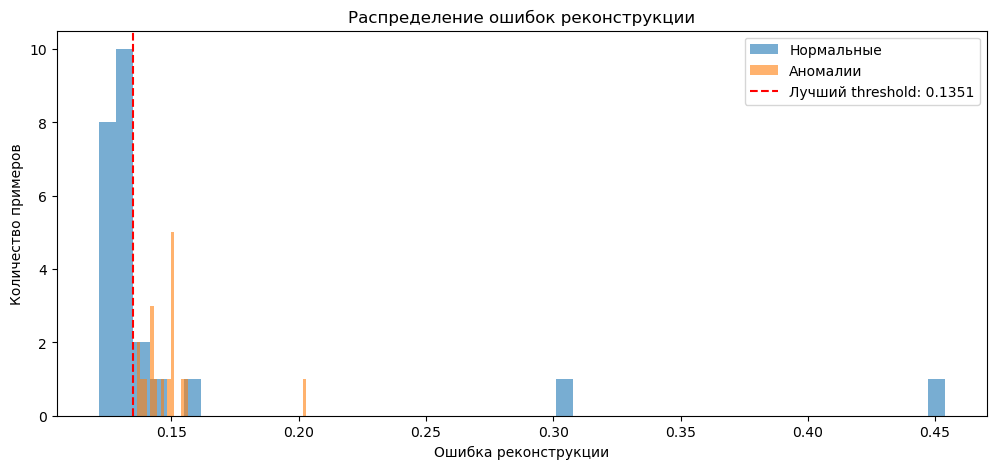

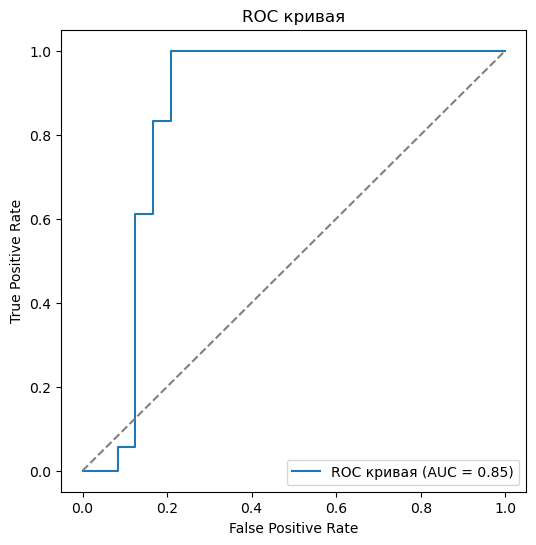

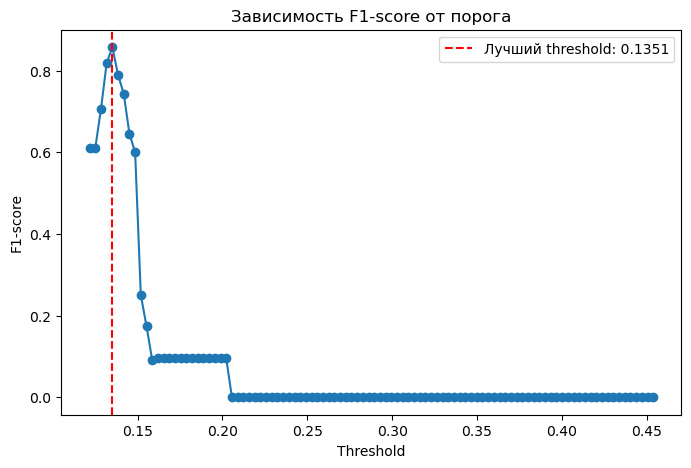

In [23]:
train_attack_category('sql-inj')


< ---------- xss ---------- >


Обучение завершено.
AUROC: 0.5175
Лучший threshold: 0.0313
Accuracy: 0.5723
Precision: 0.5740
Recall: 0.9949
F1: 0.7280
Матрица ошибок:
TN: 0.0000
FP: 144.0000
FN: 1.0000
TP: 194.0000


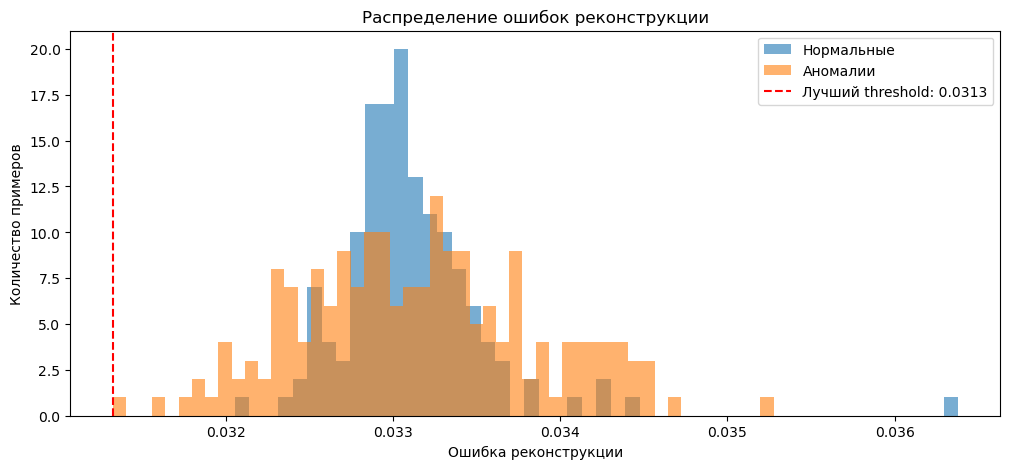

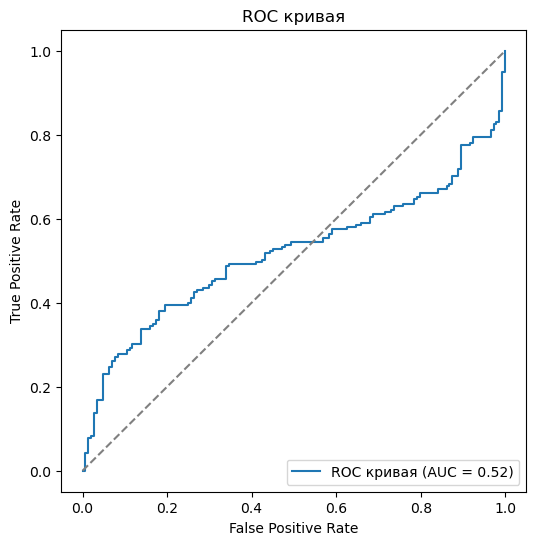

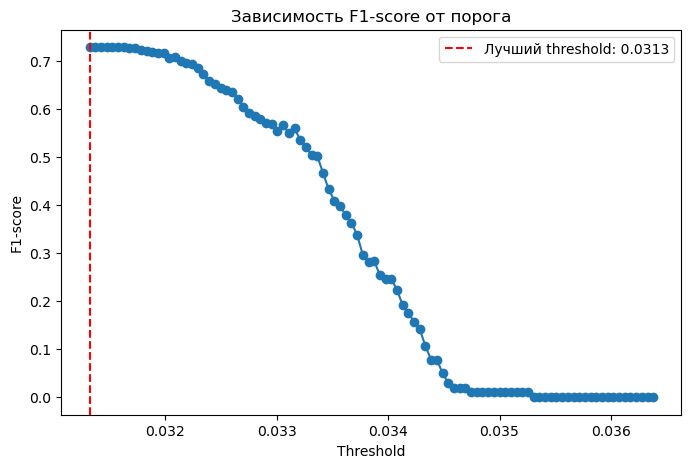

In [24]:
train_attack_category('xss')

In [25]:
# Создаем DataFrame и сохраняем в CSV
base_dir='n_packets=5_l=100'
results_df = pd.DataFrame(results)
results_df.to_csv(f'{base_dir}_attack_metrics_report.csv', index=False)
print(f"\nMetrics saved to {base_dir}_attack_metrics_report.csv")


Metrics saved to n_packets=5_l=100_attack_metrics_report.csv


In [26]:
results_df

,Attack Category,AUROC,Accuracy,Precision,Recall,F1 Score,True Negative,False Positive,False Negative,True Positive,ROC AUC
0,botnet-ares,0.454847,0.477211,0.477171,1.000000,0.646060,1,6882,0,6281,0.454847
1,brute-ftp,0.601951,0.939616,0.939609,1.000000,0.968864,1,553,0,8604,0.601951
2,brute-http,0.660728,0.545877,0.545349,1.000000,0.705794,1,391,0,469,0.660728
3,brute-ssh,0.572375,0.889950,0.890089,0.999824,0.941771,0,702,1,5685,0.572375
4,inf-dropbox,0.578017,0.664759,0.664870,0.999494,0.798544,2,1990,2,3948,0.578017
5,inf-usb,0.799496,0.943689,0.944301,0.999315,0.971029,0,86,1,1458,0.799496
6,sql-inj,0.854167,0.857143,0.750000,1.000000,0.857143,18,6,0,18,0.854167
7,xss,0.517486,0.572271,0.573964,0.994872,0.727955,0,144,1,194,0.517486
